# Evaluation: Continuous Random Variables
## Convergence of Continuous Random Variables

In [1]:
# Libraries
import numpy as np
from matplotlib import pyplot as plt
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "font.size": 14}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
import pymc3 as pm
import seaborn as sns
from functools import reduce
import theano.tensor as tt
from scipy.integrate import quad

import arviz as az
import pandas as pd
import subprocess # for calling leakiest

## Sklearn mutual info implementation
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest

## Scipy entropy/kl-divergence
from scipy.stats import entropy
from scipy.stats import norm

print("Running on PyMC3 v{}".format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


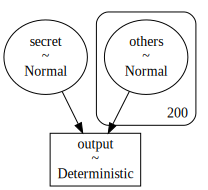

In [11]:
with pm.Model() as model:
    N1 = 1
    N2 = 200
    s  = N1+N2
    secret = pm.Normal("secret",mu=42,sigma=20,shape=N1)
    others = pm.Normal("others",mu=55,sigma=20,shape=N2)        
    output = pm.Deterministic("output",(secret.sum()+others.sum())/s)
pm.model_to_graphviz(model)

In [10]:
trace=pm.sample(20000,cores=2,tune=5000,model=model)

<ipython-input-10-e927d358f48b>:1: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(20000,cores=2,tune=5000,model=model)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [others, secret]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 24 seconds.


### Probability Queries

In [12]:
### Build the model with the sigma of `secret` and `others` equals 20
### This is necessary for making the probability queries plot
trace10=pm.sample(20000,cores=2,tune=5000,model=model)

<ipython-input-12-8899a66f5371>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace10=pm.sample(20000,cores=2,tune=5000,model=model)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [others, secret]


Sampling 2 chains for 5_000 tune and 20_000 draw iterations (10_000 + 40_000 draws total) took 23 seconds.


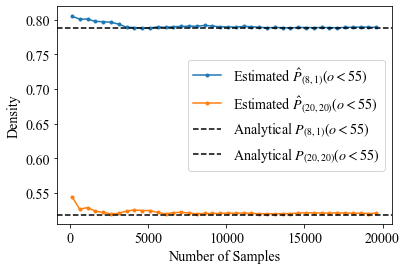

In [13]:
x=[x for x in range(100, 20000, 500)]
y=[np.mean(trace[:i]['output']<55) for i in x]
y1=[np.mean(trace10[:i]['output']<55) for i in x]
plt.plot(x,y,label='Estimated $\hat{P}_{(8,1)}(o<55)$',marker='.')
plt.plot(x,y1,label='Estimated $\hat{P}_{(20,20)}(o<55)$',marker='.')
### Analytical solutions
plt.axhline(y=norm.cdf(55,loc=54.93532338308458,scale=0.08083620303120359), 
            linestyle='--', color='black',  label='Analytical $P_{(8,1)}(o<55)$')
plt.axhline(y=norm.cdf(55,loc=54.93532338308458,scale=1.4106912317171965), 
            linestyle='--', color='black',  label='Analytical $P_{(20,20)}(o<55)$')
plt.locator_params(axis="x", nbins=6)
plt.legend(loc='best')
plt.ylabel('Density')
plt.xlabel('Number of Samples')
plt.show()

### Mutual Information

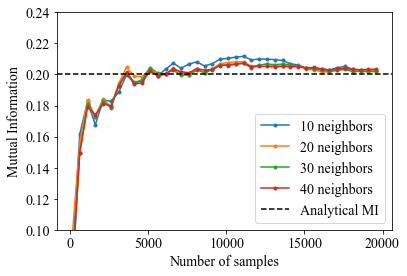

In [14]:
def mi_sklearn(t,disc_features,n_neigh):
    mi_nat = mutual_info_regression(t['secret'].reshape(-1,1), t['output'], 
                                    discrete_features=disc_features,n_neighbors=n_neigh)
    return mi_nat[0]/np.log(2)

x=[x for x in range(100, 20000, 500)]
y1=[mi_sklearn(trace[:i],False,10) for i in x]
y2=[mi_sklearn(trace[:i],False,20) for i in x]
y3=[mi_sklearn(trace[:i],False,30) for i in x]
y4=[mi_sklearn(trace[:i],False,40) for i in x]

plt.plot(x,y1,label='10 neighbors',marker='.')
plt.plot(x,y2,label='20 neighbors',marker='.')
plt.plot(x,y3,label='30 neighbors',marker='.')
plt.plot(x,y4,label='40 neighbors',marker='.')
# Analytical solution
plt.axhline(y=0.2002689647918644, linestyle='--', color='black',  label='Analytical MI')
plt.ylim((0.1,0.24))
plt.locator_params(axis="x", nbins=6)
plt.legend(loc='best')
plt.ylabel('Mutual Information')
plt.xlabel('Number of samples')
plt.show()

## Scability of Continuous Random Variables

The data below is collected by running the program above with differen number of varaibles, i.e., changing the varaible `N`.

| Nr of vars  | Time (s) |
|-------------|----------|
| 200         | 30       |
| 500         | 40       |
| 1000        | 50       |
| 5000        | 80       |
| 7000        | 120      |
| 10000       | 1200     |
| 20000       | 2400     |

We plot this data together with the regression line they conform.

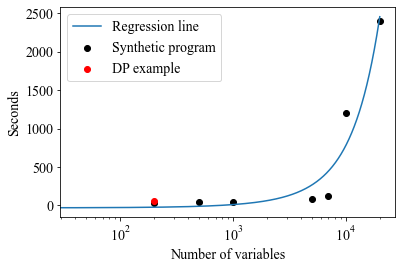

In [15]:
# data
#         No. 	x 	y
#         1 	200 	30
#         2 	500 	40
#         3 	1000 	50
#         4 	5000 	80
#         5 	7000 	120
#         6 	10000 	1200
#         7 	20000 	2400

## These parameters are calculated using an online regression tool using the data above
a=-31.3725342
b=0.03784654754
c=4.320801008*10**-6
x=np.linspace(0,20000,500)
f=lambda x: (c*x**2)+(b*x)+a
plt.plot(x,f(x),label='Regression line')
plt.scatter([200,500,1000,5000,7000,10000,20000],
            [30,40,50,80,120,1200,2400],
           color='black',label='Synthetic program')
plt.scatter([200],
            [60],
           color='red',label='DP example')
plt.xlabel('Number of variables')
plt.ylabel('Seconds')
plt.gcf().subplots_adjust(bottom=0.15)
# plt.title('Scalability continuous random variables')
plt.xscale('log')
plt.legend(loc='best')
plt.savefig('scalability-continuous.pdf')
plt.show()